In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [5]:
## update data
def filter_df(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [6]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])

In [7]:
# filter data to make sure only ages from both dataset appear in subsequent analysis
mask = data.index.get_level_values('age').intersection(data_dana.index.get_level_values('age'))
fdata = data[data.index.get_level_values('age').isin(mask)]
fdata_dana = data_dana[data_dana.index.get_level_values('age').isin(mask)]
fdata_all = pd.concat([fdata,fdata_dana])

In [8]:
## PC COMPARISONS

In [9]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(np.log(fdata + 1e-6))

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print (cumulative_variance_explained)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = fdata.index.get_level_values('age')

[0.38864489 0.54515395]


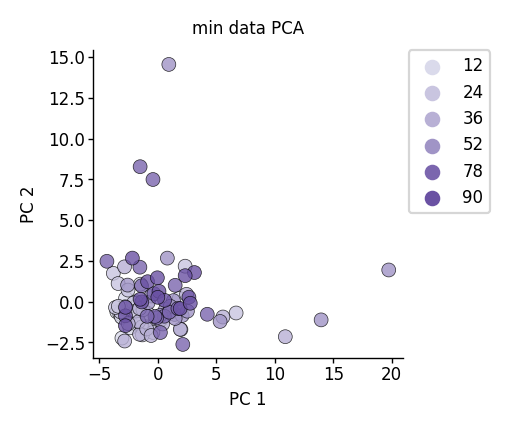

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2) 
sns.scatterplot(data=pc_df, x=pc_df[0], y=pc_df[1], 
                hue="age",
                palette=cmm,
                legend="full",
                s=25,
                alpha=0.8,
                edgecolor='black',
                linewidth=0.25,
                ax=ax
               )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("min data PCA")
#plt.title("pca males")
sns.despine()

#norm = plt.Normalize(pc_df['age'].min(), pc_df['age'].max())
#sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
#sm.set_array([])

# Remove the legend and add a colorbar
#ax.get_legend().remove()
#ax.figure.colorbar(sm)
plt.show()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


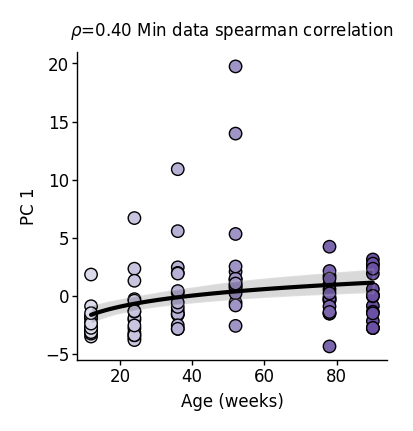

In [11]:
#PC1 correlation
from scipy import stats
[c,p] = stats.spearmanr(pc_df[0], fdata.index.get_level_values('age'))
fig, ax = plt.subplots()
fig.set_size_inches(2,2) 
im = plt.scatter(x=pc_df['age'], y=pc_df[0], 
            s=20, 
            c=pc_df['age'], 
            edgecolor='black',
            linewidth=0.5,
            #norm='log',
            cmap=cmm)
#cb=fig.colorbar(im,ax=ax)
plt.title(f'$\\rho$={c:0.2f} Min data spearman correlation')
ax = sns.regplot(data=pc_df, x='age', y=pc_df[0], scatter=False, color='black', logx=True)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
sns.despine()

In [12]:
n=10
pca = PCA(n_components=n)
pcs = pca.fit_transform(np.log(fdata + 1e-6))

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print (cumulative_variance_explained)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = fdata.index.get_level_values('age')

[0.38864489 0.54515395 0.64589255 0.72176518 0.77460185 0.8230456
 0.85218642 0.87043576 0.88741041 0.90194492]


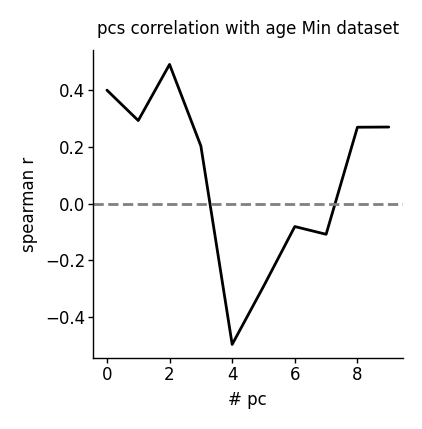

In [13]:
correlations = pc_df.loc[:,0:n-1].apply(lambda col: col.corr(pc_df['age'], method='spearman'))
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.lineplot(correlations,c='black')
plt.title('pcs correlation with age Min dataset')
plt.xlabel('# pc')
plt.ylabel('spearman r')
sns.despine()
ax.axhline(y=0, color='gray', linestyle='--')

In [14]:
#pc dana data

In [15]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(np.log(fdata_dana + 1e-6))

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print (cumulative_variance_explained)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = fdata_dana.index.get_level_values('age')

[0.50118537 0.59632082]


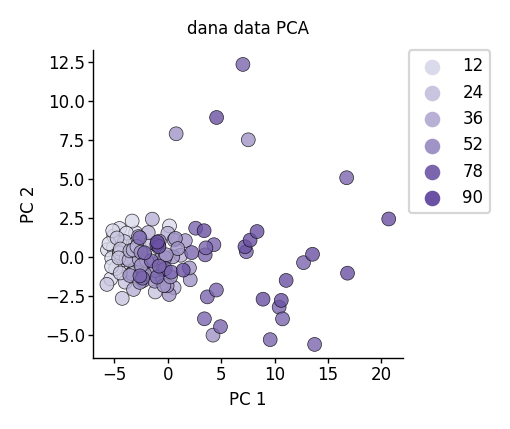

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2) 
sns.scatterplot(data=pc_df, x=pc_df[0], y=pc_df[1], 
                hue="age",
                palette=cmm,
                legend="full",
                s=25,
                alpha=0.8,
                edgecolor='black',
                linewidth=0.25,
                ax=ax
               )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("dana data PCA")
#plt.title("pca males")
sns.despine()

#norm = plt.Normalize(pc_df['age'].min(), pc_df['age'].max())
#sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
#sm.set_array([])

# Remove the legend and add a colorbar
#ax.get_legend().remove()
#ax.figure.colorbar(sm)
plt.show()

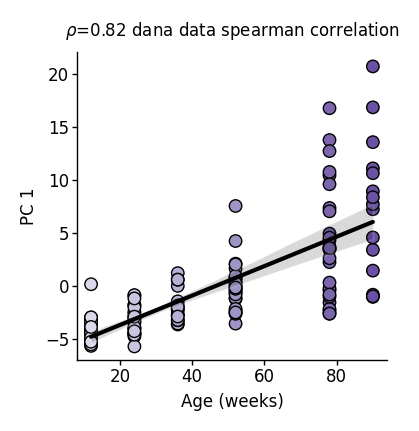

In [17]:
#PC1 correlation
from scipy import stats
[c,p] = stats.spearmanr(pc_df[0], fdata_dana.index.get_level_values('age'))
fig, ax = plt.subplots()
fig.set_size_inches(2,2) 
im = plt.scatter(x=pc_df['age'], y=pc_df[0], 
            s=20, 
            c=pc_df['age'], 
            edgecolor='black',
            linewidth=0.5,
            #norm='log',
            cmap=cmm)
#cb=fig.colorbar(im,ax=ax)
plt.title(f'$\\rho$={c:0.2f} dana data spearman correlation')
ax = sns.regplot(data=pc_df, x='age', y=pc_df[0], scatter=False, color='black', logx=False)
ax.set(xlabel='Age (weeks)', ylabel='PC 1')
sns.despine()

In [18]:
n=10
pca = PCA(n_components=n)
pcs = pca.fit_transform(np.log(fdata_dana + 1e-6))

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print (cumulative_variance_explained)

pc_df = pd.DataFrame(pcs)
pc_df['age'] = fdata_dana.index.get_level_values('age')

[0.50118537 0.59632082 0.66759807 0.72114834 0.76093599 0.79610906
 0.82773392 0.85372143 0.87478864 0.89457318]


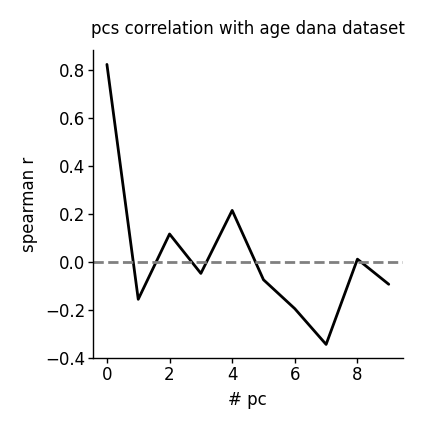

In [19]:
correlations = pc_df.loc[:,0:n-1].apply(lambda col: col.corr(pc_df['age'], method='spearman'))
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.lineplot(correlations,c='black')
plt.title('pcs correlation with age dana dataset')
plt.xlabel('# pc')
plt.ylabel('spearman r')
sns.despine()
ax.axhline(y=0, color='gray', linestyle='--')

Text(0.5, 0, 'PC3')

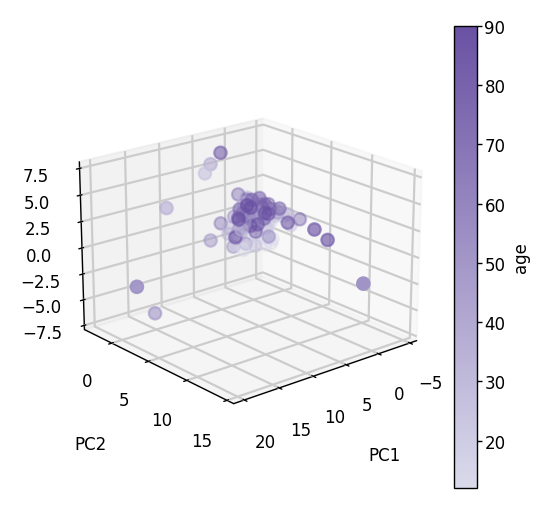

In [20]:
## 3D scatter
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

pcs3 = PCA(n_components=3).fit_transform(np.log(fdata + 1e-6))
ages = fdata.index.get_level_values('age')
pc3_df = pd.DataFrame(pcs3)
pc3_df['age'] = ages

# Create a 3D figure
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pc3_df[0], pc3_df[1], pc3_df[2], c=ages, cmap=cmm)

cbar = plt.colorbar(scatter)
cbar.set_label('age')

# Set custom viewing angles (elevation, azimuthal)
ax.view_init(elev=20, azim=50)

# Set labels for each axis
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [21]:
## syllables over time

In [22]:
# for min's data
# arrange data
data_labels = fdata.index.get_level_values('age').to_numpy()
data = fdata.to_numpy()

In [23]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

<Figure size 1200x1200 with 0 Axes>

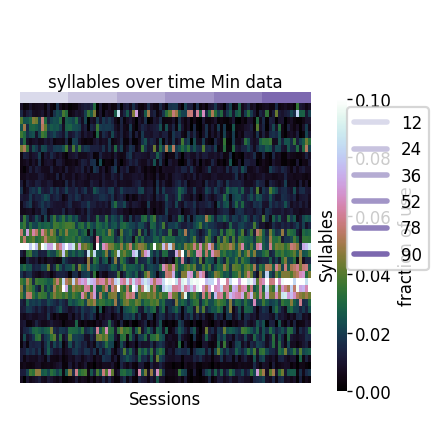

In [24]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=data.T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=True,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    #metric='sqeuclidean',
    metric='cosine',
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.1)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('syllables over time Min data')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)

plt.show()

In [25]:
# for dana's data
# arrange data
data_labels = fdata_dana.index.get_level_values('age').to_numpy()
data = fdata_dana.to_numpy()

In [26]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

<Figure size 1200x1200 with 0 Axes>

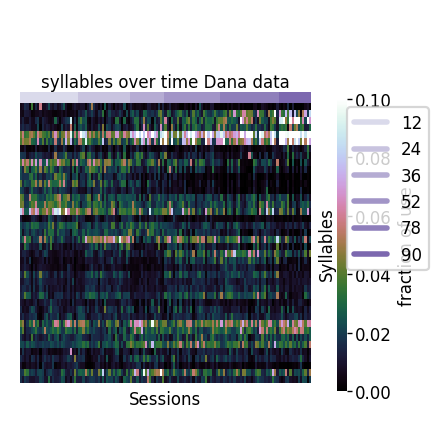

In [27]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=data.T,
    cmap=seqmatcolor, 
    figsize=(2, 2),
    col_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=True,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    #metric='sqeuclidean',
    metric='cosine',
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmax=0.1)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('syllables over time Dana data')

# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)

plt.show()

In [28]:
## correlation matrix
from scipy.spatial.distance import pdist, squareform

In [29]:
# get JSD
kld = squareform(pdist(fdata, metric='jensenshannon'))
#dm[np.diag_indices_from(dm)] = np.nan
data_labels=fdata.index.get_level_values('age').to_numpy()

In [30]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

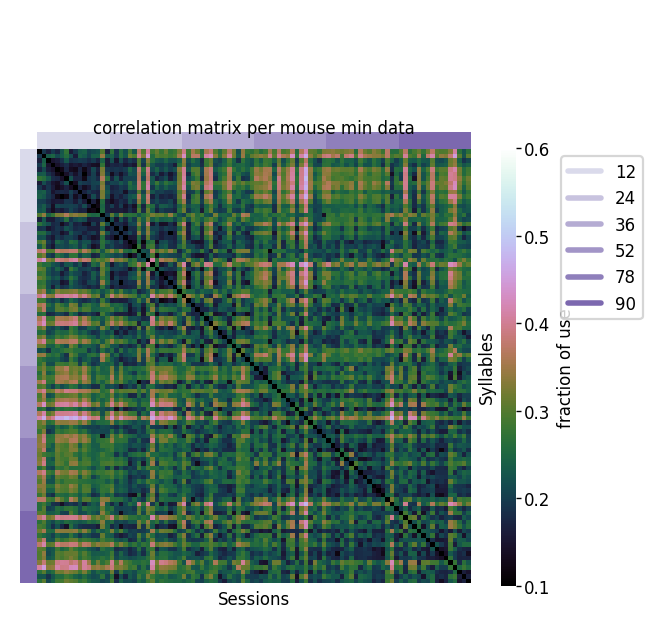

In [31]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    metric='sqeuclidean',
    #metric='cosine',
    rasterized=True,
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.1,
    vmax=0.6)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('correlation matrix per mouse min data')
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [32]:
# get JSD
kld = squareform(pdist(fdata_dana, metric='jensenshannon'))
#dm[np.diag_indices_from(dm)] = np.nan
data_labels=fdata_dana.index.get_level_values('age').to_numpy()

In [33]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

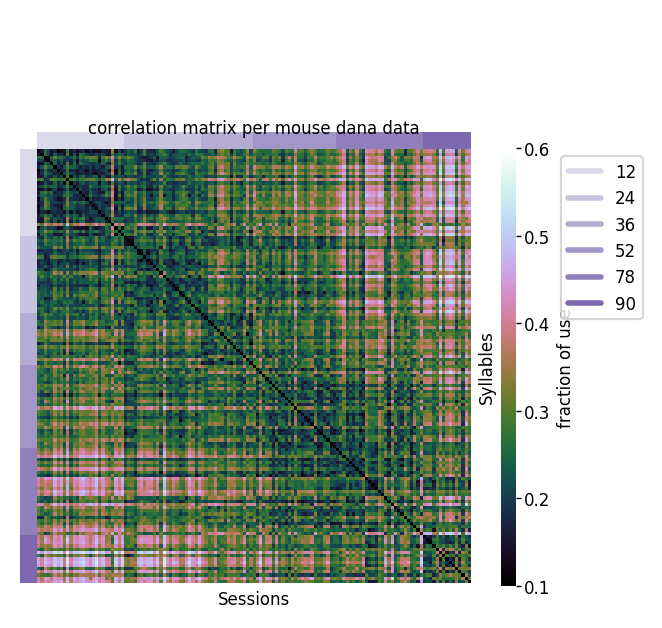

In [34]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    #method = 'single',
    metric='sqeuclidean',
    #metric='cosine',
    rasterized=True,
    #metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.1,
    vmax=0.6)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
ax.set_title('correlation matrix per mouse dana data')
# legend
for i,c in enumerate(colors):
        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [35]:
## pca of both datasets

In [36]:
# use only common ages
fdata['sex'] = 'min'
fdata.set_index('sex',inplace=True,append=True)

fdata_dana['sex'] = 'dana'
fdata_dana.set_index('sex',inplace=True,append=True)

data=pd.concat([fdata_dana,fdata])

In [37]:
pc = PCA(n_components=2)
pc.fit(data)
pcs_male = pc.transform(fdata)
pcs_female = pc.transform(fdata_dana)

pcm = pd.DataFrame(pcs_male)
pcm['psd'] = fdata.index.get_level_values('age')

pcf = pd.DataFrame(pcs_female)
pcf['psd'] = fdata_dana.index.get_level_values('age')

In [38]:
variance_explained = pc.explained_variance_ratio_

# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [39]:
cumulative_variance_explained

array([0.41163981, 0.56095725])

Text(0.5, 1.0, 'pca fit on both')

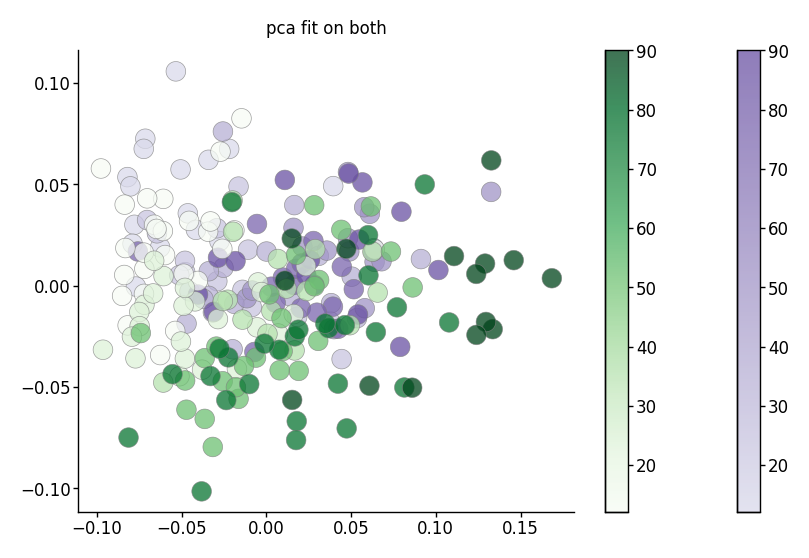

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3) 
im = plt.scatter(x=pcm[0], y=pcm[1], 
                cmap=cmm,
                s=50,
                edgecolor='grey',
                c=pcm['psd'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
im2=plt.scatter(x=pcf[0], y=pcf[1], 
                cmap='Greens',
                s=50,
                edgecolor='grey',
                c=pcf['psd'], 
                linewidth=0.25,
                #norm='log',
                alpha=0.75,
               )
cb=fig.colorbar(im2,ax=ax)
sns.despine()
c = PlotConfig()
plt.title('pca fit on both')
#fig.savefig(c.dana_save_path / "fig4"/ 'fvm_pca_fit_on_both.pdf')

In [63]:
data_temp = data_all.copy()
mdata = data_temp.query('data=="min"')
ddata = data_temp.query('data=="dana"')

In [64]:
pc = PCA(n_components=2)
pcs=pc.fit_transform(data_temp)

pcs_male = pc.transform(mdata)
pcs_female = pc.transform(ddata)

pcm = pd.DataFrame(pcs_male)
pcf = pd.DataFrame(pcs_female)

pcm['psd'] = mdata.index.get_level_values('age')
pcf['psd'] = ddata.index.get_level_values('age')

In [65]:
variance_explained = pc.explained_variance_ratio_

# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [66]:
cumulative_variance_explained

array([0.39512222, 0.59055058])

Text(0.5, 1.0, 'pca fit on both')

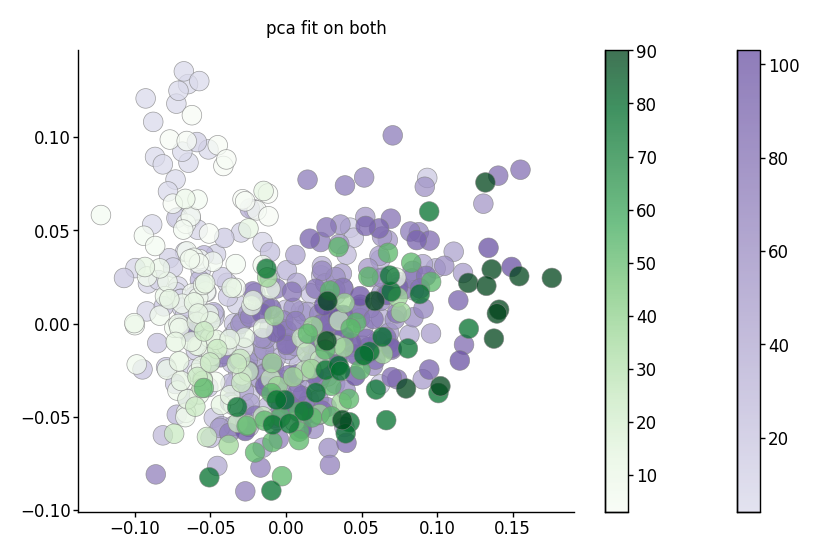

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3) 
im = plt.scatter(x=pcm[0], y=pcm[1], 
                cmap=cmm,
                s=50,
                edgecolor='grey',
                c=pcm['psd'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
im2=plt.scatter(x=pcf[0], y=pcf[1], 
                cmap='Greens',
                s=50,
                edgecolor='grey',
                c=pcf['psd'], 
                linewidth=0.25,
                #norm='log',
                alpha=0.75,
               )
cb=fig.colorbar(im2,ax=ax)
sns.despine()
c = PlotConfig()
plt.title('pca fit on both')
#fig.savefig(c.dana_save_path / "fig4"/ 'fvm_pca_fit_on_both.pdf')

In [68]:
#umap
import warnings

# Binning / smoothing
    
def firing_rates(
    spike_times, 
    spike_labels, 
    window_size=0.2, 
    window_step=0.02
):
    """Convert spike tikes to firing rates using a sliding window
    
    Parameters
    ----------
    spike_times : ndarray
        Spike times (in seconds) for all units. The source of each spike is
        input separately using ``spike_labels``
        
    spike_labels: ndarray
        The source/label for each spike in ``spike_times``. The maximum
        value of this array determines the number of rows in the heatmap.
    
    window_size: float, default=0.2
        Length (in seconds) of the sliding window used to calculate firing rates
        
    window_step: float, default=0.02
        Step-size (in seconds) between each window used to calculate firing rates
    Returns
    -------
    firing_rates: ndarray
        Array of firing rates, where rows units and columns are sliding 
        window locations. ``firing_rates`` has shape ``(N,M)`` where::
            N = max(spike_labels)+1
            M = (max(spike_times)-min(spike_times))/binsize
    start_time, float
        The time (in seconds) corresponding to the left-boundary
        of the first window in ``firing_rates``.
    """
    # round spikes to window_step and factor our start time
    spike_times = np.around(spike_times/window_step).astype(int)
    start_time = spike_times.min()
    spike_times = spike_times - start_time
    
    # create heatmap of spike counts for each window_step-sized bin
    spike_labels = spike_labels.astype(int)
    heatmap = np.zeros((spike_labels.max()+1, spike_times.max()+1))
    np.add.at(heatmap, (spike_labels, spike_times), 1/window_step)
    
    # use convolution to get sliding window counts
    kernel = np.ones(int(window_size//window_step))/(window_size//window_step)
    for i in range(heatmap.shape[0]): heatmap[i,:] = np.convolve(heatmap[i,:],kernel, mode='same')
    return heatmap, start_time-window_step/2


def bin_data(
    data, 
    binsize,
    axis=-1,
    return_intervals=False
):
    """Bin data using non-overlaping windows along `axis`
    Returns
    -------
    data_binned: ndarray
    bin_intervals: ndarray (returned if ``rerturn_intervals=True``)
        (N,2) array with the start and end index of each bin
    """
    data = np.moveaxis(data,axis,-1)
    pad_amount = (-data.shape[-1])%binsize
    num_bins = int((data.shape[-1]+pad_amount)/binsize)

    data_padded = np.pad(data,[(0,0)]*(len(data.shape)-1)+[(0,pad_amount)])
    data_binned = data_padded.reshape(*data.shape[:-1], num_bins, binsize).mean(-1)
    if pad_amount > 0: data_binned[...,-1] = data_binned[...,-1] * binsize/(binsize-pad_amount)
    data_binned = np.moveaxis(data_binned,-1,axis)

    if return_intervals:
        bin_starts = np.arange(0,num_bins)*binsize
        bin_ends = np.arange(1,num_bins+1)*binsize
        bin_ends[-1] = data.shape[-1]
        bin_intervals = np.vstack((bin_starts,bin_ends)).T
        return data_binned, bin_intervals
    else: return data_binned



# Normalization

def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std


# Dimensionality reduction

def sort(
    data, 
    method='rastermap', 
    options={}
):
    """Compute neuron ordering that groups neurons with similar activity
    Parameters
    ----------
    data: ndarray
        Data matrix where rows are neurons and columns are time points
    method: {'rastermap'}
        Method to use for sorting (currently only rastermap is implemented)
    options: dict, default={}
        Sorting method-specific options.
        'rastermap'
            ``options`` will be passed as keyword arguments when initializing
            `rastermap.mapping.Rastermap <https://github.com/MouseLand/rastermap/blob/40867ce9a8b2850d76483890740c0dc10d6cb413/rastermap/mapping.py#L531>`_
    Returns
    -------
    ordering: ndarray
        Ordering index that can be used for sorting (see `numpy.argsort`)
    """
    valid_sort_methods = ['rastermap']
    if not method in valid_sort_methods:
        raise AssertionError(method+' is not a valid sort method. Must be one of '+repr(valid_sort_methods))
    if method=='rastermap':
        print('Computing row order with rastermap')
        from rastermap import mapping
        model = mapping.Rastermap(n_components=1).fit(data)
        return np.argsort(model.embedding[:,0])


def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        Array of neural activity where rows are neurons and columns are time points
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

In [89]:
data_umap = data_all.groupby(['age','data','uuid']).mean().copy()
exp = data_umap.index.get_level_values('data').unique().to_numpy()
data_umap_labels = data_umap.index.get_level_values('data').to_numpy()
# actual umap
coordinates = umap_embedding(data_umap.T, 
        standardize=False,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=10,
        random_state=42)

In [90]:
# transform exp type to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

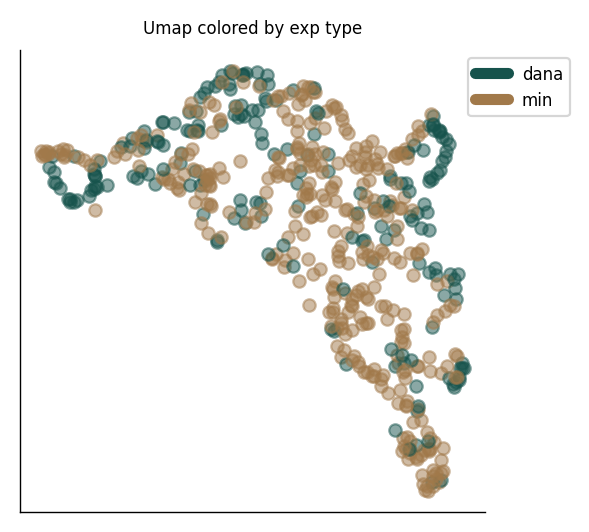

In [91]:
# plot
# prepare colors for plot
phasec = sns.color_palette("cubehelix", 3)
custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by exp type',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()
#fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')

In [92]:
exp = data_umap.index.get_level_values('age').unique().to_numpy()
data_umap_labels = data_umap.index.get_level_values('age').to_numpy()

In [93]:
# transform exp type to labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
le.fit(exp)
y = le.transform(data_umap_labels)

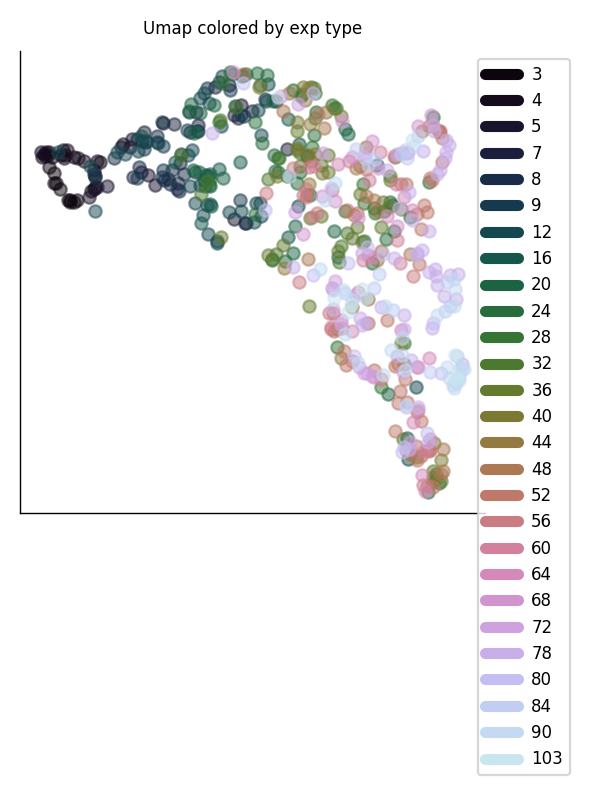

In [94]:
# plot
# prepare colors for plot
phasec = sns.color_palette("cubehelix", 30)

custom_lines=[]
for i in range(len(exp)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
    
fig, ax = plt.subplots()
fig.set_size_inches(3,3)  
plt.legend(handles=custom_lines,labels=list(exp),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by age both exp',fontsize=6)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(),alpha=0.5, s=20)
sns.despine()
#fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')

In [41]:
## decoder

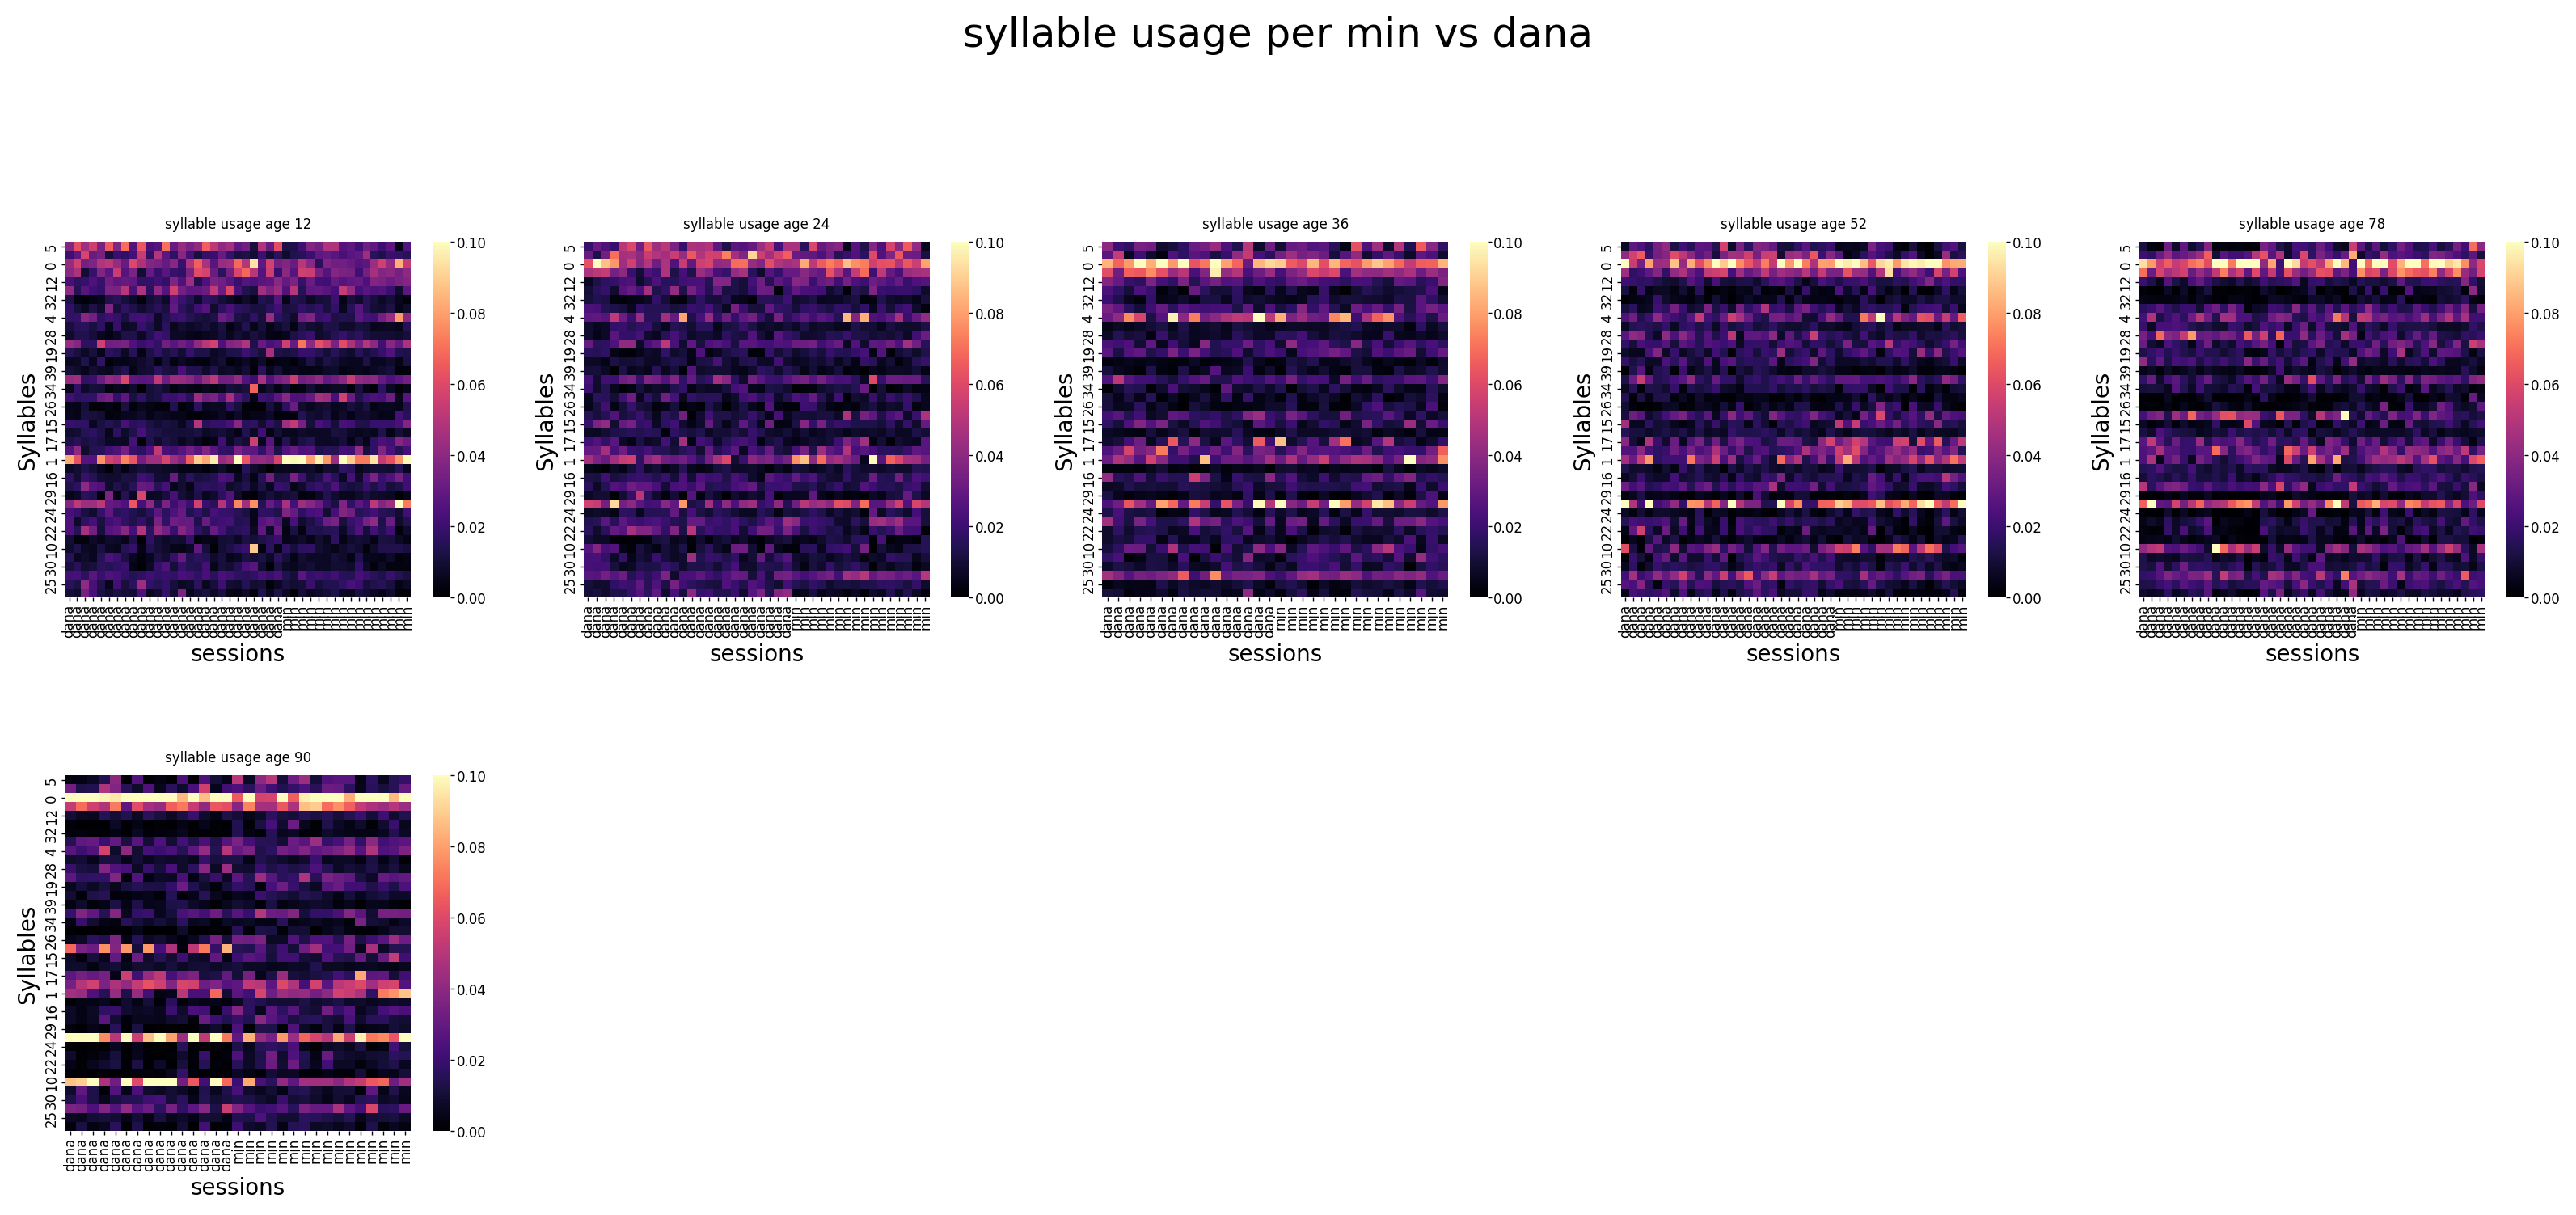

In [42]:
n=0
fig=plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("syllable usage per min vs dana", fontsize=18, y=0.95)
for age,_df in enumerate(data.groupby('age')):
    #ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    x = _df[1]
    sex = _df[1].index.get_level_values('sex').to_numpy()
    ax = plt.subplot(5, 5, n + 1)
    sns.heatmap(x.T,cmap = 'magma',vmax=0.1, xticklabels= sex)
    ax.set_title('syllable usage age ' + str(_df[0]))
    ax.set_ylabel('Syllables',fontsize=10)
    ax.set_xlabel('sessions',fontsize=10)
    n=n+1

In [43]:
# distance between exp

In [44]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            cohort_dist[x,y]=scipy.spatial.distance.jensenshannon(p=np.array(i), q=np.array(j))
            
            y=y+1
        y=0
        x=x+1
    #cohort_dist[cohort_dist==0]='nan'
    return cohort_dist

In [45]:
data_temp=fdata_all.groupby(['age','data']).mean()

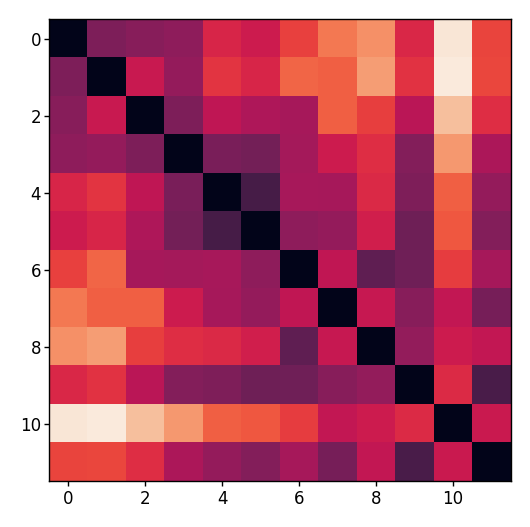

In [46]:
kld = KLD_analysis(data_temp.to_numpy())
plt.imshow(kld)

In [47]:
#colors for plotting
data_labels = data_temp.index.get_level_values('data').to_numpy()
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

<Figure size 1200x1200 with 0 Axes>

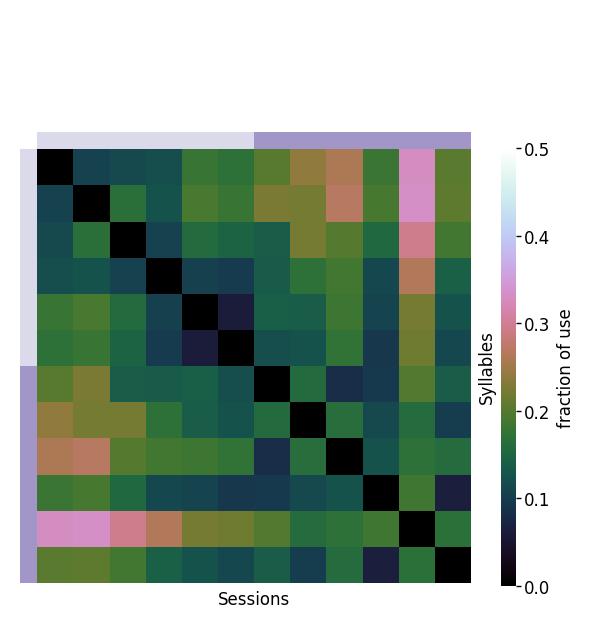

In [48]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.0,
    vmax=0.5,
)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
plt.show()

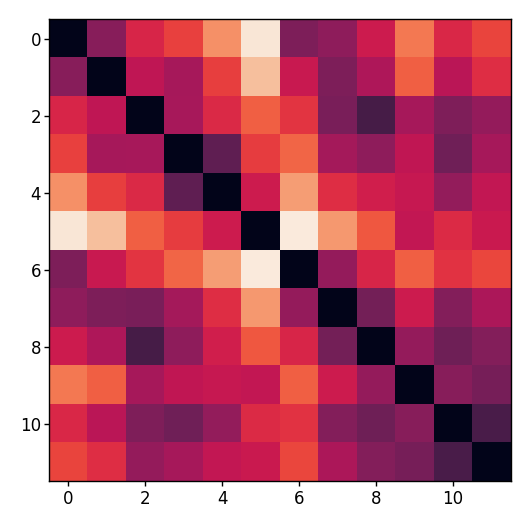

In [49]:
data_temp=fdata_all.groupby(['data','age']).mean()
kld = KLD_analysis(data_temp.to_numpy())
plt.imshow(kld)

In [50]:
#colors for plotting
data_labels = data_temp.index.get_level_values('age').to_numpy()
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

<Figure size 1200x1200 with 0 Axes>

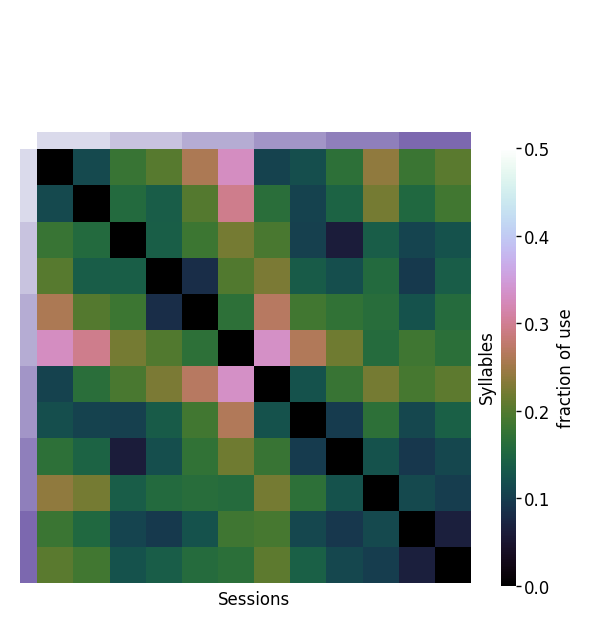

In [51]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.0,
    vmax=0.5,
)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
plt.show()

In [52]:
# pca for all the data